# Statistical Thermodynamics CA 2

In [1]:
print("""Bevin Kelleher
St. 22335235
March 31, 2025""")

Bevin Kelleher
St. 22335235
March 31, 2025


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import scipy.constants as sc
from numba import njit
from scipy.stats import linregress


## Question 2

(a) Create a 1000x2 array z initialized to have all zero-valued elements using a oneliner Python statement.

In [3]:
z = np.zeros((1000, 2))
#need 2 paretheses as input needs to be a single argument - here, it's a tuple

(b) Define a function with input arguments consisting of an array z of floating point
numbers along with two additional floating point numbers a and b. The
function should return the sum of the elements of the array to the power of a and
b as two numbers separated by commas. Call the function with a 10 element
array of random numbers between 0 and 1 and pass values 2 and 3 for a and b.
Place the returned number pair into variables x and y.

In [4]:
def sum_function(z,a,b):
    z_sum = np.sum(z)
    return z_sum**a,z_sum**b

random_array = np.random.rand(10)

x,y = sum_function(random_array,2,3)

print(f"x = {x}")
print(f"y = {y}")

x = 8.104283175847405
y = 23.071291757909627


(c) Create a real-number (“floating point”) array of 500 random valued elements
drawn from a Gaussian distribution. Plot a histogram of these values showing at
least ±3 sigma (standard deviations) with 20 bins.

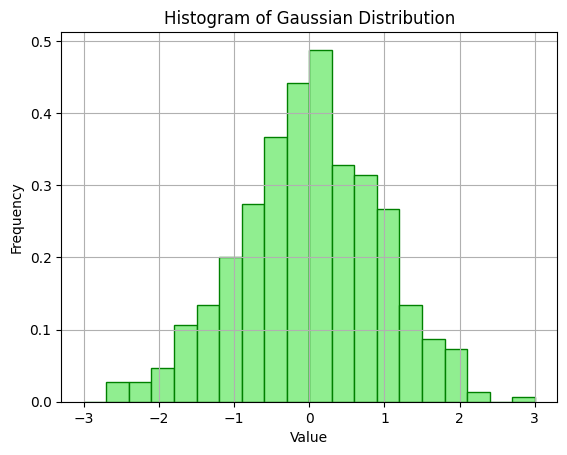

In [5]:
data = np.random.normal(loc=0.0, scale=1.0, size=500)
#normal distrib. with mean=0, std=1

plt.figure()
plt.hist(data, bins=20, range=(-3,3), color="lightgreen", edgecolor="green", density=True)
#range is +-3 std
#normalised it with density set to true

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Gaussian Distribution")
plt.grid()
plt.show()

(d) Create an array of 20 elements chosen randomly to have the value +10 or -10
(NumPy choice() function). Create and print out this array 3 times.

In [6]:
for i in range(3):
    array_number = i+1
    array_20 = np.random.choice([10,-10], size=20, replace=True)
    print(f"array {array_number}: {array_20}")

array 1: [ 10  10  10 -10 -10 -10 -10 -10  10  10 -10 -10 -10 -10 -10  10 -10  10
 -10 -10]
array 2: [-10  10 -10  10  10  10 -10 -10  10 -10  10 -10  10  10  10 -10 -10 -10
  10  10]
array 3: [-10  10  10  10 -10  10 -10  10  10  10 -10  10 -10 -10 -10  10  10 -10
  10  10]


(e) Create an empty array (eg. z=[]), and then use a 100 iteration while loop inside
a 50 iteration for loop to create and append 5000 random numbers uniformly
distributed between -50 and +50 using z.append(<number>). After the loop,
plot a histogram of z with 30 bins.

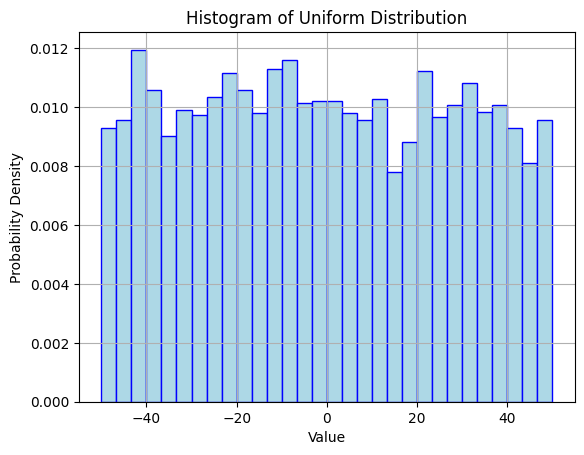

In [7]:
z = []

for i in range(50):
    iteration = 0
    while iteration < 100:
        z.append(np.random.uniform(-50,50))
        iteration += 1

plt.figure()
plt.hist(z, bins=30, color="lightblue", edgecolor="blue", density=True)
#set density to True to normalise distribution

plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("Histogram of Uniform Distribution")
plt.grid()
plt.show()

## Question 3

### Part I

Initialize the system by setting the initial piston position $X_0$ to be at twice the
equilibrium position as given by the 1D ideal gas law for a temperature $T_0$. (Think,
what does this do to the initial internal energy of the system?) Then distribute the N
initial particle positions $x_i^0$ randomly to be between $-X_0$ and $X_0$.

You can use the equipartition theorem to set a reasonable scale of the initial
velocity of the punch and particles: Assume $K= (1/2) k_B T$ goes into the kinetic
energy of each particle and the punch. For part 3(a), you can set $v_i^0$ to be a
random Gaussian value with a standard deviation of particle velocity as
calculated from K, and same for the initial punch velcity $V_0$. Note for part
3(c), you should set the $v_i^0$ to be a random value of +v0 or -v0 as set by the K
calculation to see the evolution to the Maxwell distribution.

Set an overall time measure variable t to 0.

To hold the current microstate variables of the particles, it might be
convenient to define an Nx2 array with column 1 holding particle positions
and column 2 holding particle velocities. Or you could make two separate
Nx1 arrays. You could extend the array to length N+1 to hold the piston
position and velocity (ie. representing the full microstate), or just keep those as
separate variables.

In [8]:
N = 1000
T = 1.0
kB = 1.0
m = 1.0
M = 100.0
F = 10.0
t = 0.0


In [9]:
F_div_M = F / M
#this is the acceleration of the piston from F=ma

X_eq = (N * kB * T) / F
X0 = 2 * X_eq
#twice equilibrium
#gas starts out more expanded than its equilibrium volume for a given temperature

sigma_v = np.sqrt(kB * T / m)
sigma_V = np.sqrt(kB * T / M)
#K = 0.5 * kB * T
#these are the standard deviations from the velocities

positions = np.random.uniform(-X0, X0, N)
velocities = np.random.normal(0.0, sigma_v, N)
#part a
#low=-X0, high=X0, size=N
#loc=0.0, scale=sigma_v, size=N -> loc=mean

X = X0
V = np.random.normal(0.0, sigma_V)
#loc=0.0, scale=sigma_V

#velocities = np.random.choice([+sigma_v, -sigma_v], size=N)
#V_piston = np.random.choice([+sigma_V, -sigma_V])
#part c

particles = np.zeros((N, 2))
particles[:,0], particles[:,1] = positions, velocities

piston = np.zeros((N, 2))
piston[:,0], piston[:,1] = X, V

### Part II

Evaluate the waiting times $\tau_i$ to a collision of each particle i with the piston using
answer 1 (e) and identify the index $i_0$ of the first collision with the shortest
waiting time. This smallest waiting time will be the time of the next step to evolve
the system.

The waiting time calculation might be conveniently placed in a function with
inputs x, v, X, V, and F/M, and returning $\tau_i$ to be called by a loop over all the
particles.

The answer for 1 (e) is given as:

$
\tau = \frac{M}{F} \left( (V \pm v) + \sqrt{(V \pm v)^2 \pm \frac{2F}{M}(x \pm X)} \right)
$

where the signs are **negative** for a right moving particle (v > 0), and the signs are **positive** for a left moving particle (v < 0).

*Note that x and X are positive in these expressions.*

In [10]:
@njit
def waiting_time(x, v, X, V, F_div_M):
    #use x,v here to be particle specific

    tol=1e-12

    if v > 0: #moving right, going towards +X
        term1 = V - v
        term2 = (2 * F_div_M)
        term3 = x - X
        discriminant = term1**2 - (term2 * term3)

    elif v < 0: #moving left, going towards -X
        term1 = V + v
        term2 = (2 * F_div_M)
        term3 = x + X
        discriminant = term1**2 + (term2 * term3)

    else: #v = 0, there's no motion so there's no collision
        return np.inf
        #print("no motion: no collisions")

    if discriminant < 0:
        #print("no collision: discriminant zero")
        return np.inf

    sqrt_term = np.sqrt(discriminant)
    tau = (term1 + sqrt_term) / (0.5 * term2)
    tau_value = np.inf

    if tau > tol and tau < tau_value:
        tau_value = tau

    return tau_value

@njit
def next_collision(particles, X, V, F_div_M):
    #doesn't need to be particle specific

    tau_min = np.inf
    index = -1
    #instead of initialising at 0, which would imply that the particle with index 0
    #was a valid collision

    n = particles.shape[0]

    for i in range(n):
        x = particles[i, 0]
        v = particles[i, 1]
        tau_i = waiting_time(x, v, X, V, F_div_M)

        if tau_i < tau_min:
            tau_min = tau_i
            index = i

    return tau_min, index
    #outputs the min (i.e. next) collision time and the index


### Part III and Part IV

Displace each particle i according to the equations of motion from answer 1 (c), place
the piston at the position of particle $i_0$ (i.e. the one you found it is colliding with), and
update the velocity V of the piston from answer 1 (d).

Use the answer 1 (f) to calculate new values of velocity of the particle and piston after
the collision.
The new velocities calculation may also be conveniently placed inside a
function that returns two values at once (eg. in Python you can write return
w, W).

The answers for 1 (c) are the **equations of motion** $x_i(t)$ and $v_i(t)$ of the ***ith* particle** for t $\geq$ $t_0$ given as:

$
x_i(t) = x_i^0 + v_i(t)(t-t_0)
$

$
v_i(t) = v_i^0
$

The answers for 1 (d) are the **equations of motion** $X(t)$ and $V(t)$ of the piston for t $\geq$ $t_0$ given as:

$
X(t) = - \frac{F}{2M} (t-t_0)^2 + V_0(t-t_0) + X_0
$

$
V(t) = - \frac{F}{M} (t-t_0) + V_0
$

Assuming purely elastic collisions preserving kinetic energy and momentum, the answers for 1 (f) are the velocities *w* and *W* of the piston and a particle **immediately after** the collision between them, given as:

$
w = \frac{\pm 2MV + v(m-M)}{m+M}
$

$
W = \frac{\pm 2mv + V(M-m)}{m+M}
$

where the signs are **positive** for a right moving particle (v > 0), and the signs are **negative** for a left moving particle (v < 0).

In [11]:
@njit
def velocities_function(v, V, m, M):
    if v > 0: #right moving particle
        w = ((2 * M * V) + v * (m - M)) / (m + M)
        W = ((2 * m * v) + V * (M - m)) / (m + M)

    elif v < 0:
        w = ((-2 * M * V) + v * (m - M)) / (m + M)
        W = ((-2 * m * v) + V * (M - m)) / (m + M)

    else:
        w, W = 0, V
        #print("no collisions: no velocity changes to w, W")

    return w, W
    #these are the velocities of the particle and piston, IMMEDIATELY post a 1D elastic collision

@njit
def updating_xv(particles, X, V, F_div_M, tau, index, m, M):
    n = particles.shape[0]
    new_particles = np.empty_like(particles)
    #empty array for updates

    for i in range(n):
        x_i = particles[i, 0]
        v_i = particles[i, 1]
        #current particle

        x_new = v_i * tau + x_i
        #updates using 1(c) answers

        new_particles[i, 0] = x_new
        new_particles[i, 1] = v_i #doesn't change here

    #new_X = new_particles[i_0, 0]
    #places piston at position of colliding particle
    #redundant cause it's immediately written over?

    X_new = - (F_div_M / 2) * tau**2 + V * tau + X
    V_new = - (F_div_M) * tau + V
    #updates using 1(d) answers

    if index != -1: #collision did happen
        v_collision = new_particles[index, 1]
        w, W = velocities_function(v_collision, V_new, m, M)
        new_particles[index, 1] = w
        V_new = W

    return new_particles, X_new, V_new


### Part V and VI

Increase the time measure by $\tau_{i_0}$. Store the values of $\tau_{i_0}$, X, and V computed at this time step in arrays representing a time series of the piston motion.

Loop back to part II and repeat enough times to complete 20 physical oscillations of the punch position as it settles down about an equilibrium value (which should correspond to that produced by the 1D gas law). The number of repeats of the outer loop should be approximately 20 times the number of particles N.


In [12]:
@njit
def simulation(N, T, kB, m, M, F, n_iterations):
    t = 0.0
    F_div_M = F / M

    X_eq = (N * kB * T) / F
    X0 = 2 * X_eq
    #twice equilibrium
    #gas starts out more expanded than its equilibrium volume for a given temperature

    sigma_v = np.sqrt(kB * T / m)
    sigma_V = np.sqrt(kB * T / M)
    #K = 0.5 * kB * T

    positions = np.random.uniform(-X0, X0, int(N))
    velocities = np.random.normal(0.0, sigma_v, int(N))
    #low=-X0, high=X0, size=N
    #loc=0.0, scale=sigma_v, size=N -> loc=mean

    #changed "N" to int(N) for numba

    particles = np.empty((N, 2))

    particles[:, 0] = positions
    particles[:, 1] = velocities

    X = X0
    V = np.random.normal(0.0, sigma_V)

    #piston = np.zeros((N, 2))
    #piston[:,0], piston[:,1] = X, V
    #unnecessary?

    time_series = np.empty(n_iterations)
    X_series = np.empty(n_iterations)
    V_series = np.empty(n_iterations)
    tau_series = np.empty(n_iterations)

    for iteration in range(n_iterations):
        tau_min, index = next_collision(particles, X, V, F_div_M)
        particles, X, V = updating_xv(particles, X, V, F_div_M, tau_min, index, m, M)

        t += tau_min

        time_series[iteration] = t
        X_series[iteration] = X
        V_series[iteration] = V
        tau_series[iteration] = tau_min

    return time_series, X_series, V_series, tau_series


# Problems

# (a)

Compose a program to calculate and plot a time series of the motion of the piston as it
performs a damped oscillation towards equilibrium (eg position X(t) vs t). Each time step
should be recorded for the next collision of the piston with a particle. Run the program for
enough time steps to get 20 or more oscillations for **N=1000 particles**. You should use the
following initial values (unitless, with $k_B$ = 1):
 - m = 1
 - M = 100
 - $T_0$ = 1
 - F = 10 (pointing towards origin)

The initial piston position X0 should be twice the value predicted by the 1D ideal gas law for T0=1.
Calculate the expected piston equilibrium position for these initial conditions and show this as a dotted
horizontal line on your plot. Comment on all features of your results.

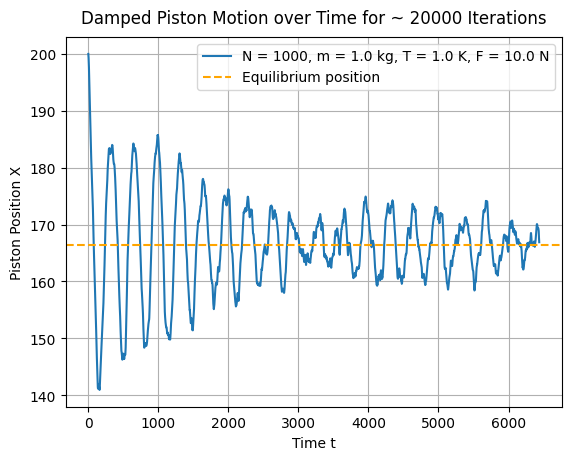

In [13]:
N = 1000
T = 1.0
kB = 1.0
m = 1.0
M = 100.0
F = 10.0
n_iterations = 20 * N

t = 0.0 #set in simulation anyway

time_series, X_series, V_series, tau_series = simulation(N, T, kB, m, M, F, int(n_iterations))

#changed n_iterations to int(n_iterations) for numba

plt.figure()
plt.plot(time_series, X_series, label=f"N = {N}, m = {m} kg, T = {T} K, F = {F} N")
plt.axhline(y=np.mean(X_series), color="orange", linestyle="--", label="Equilibrium position")

plt.xlabel("Time t")
plt.ylabel("Piston Position X")
plt.title(f"Damped Piston Motion over Time for ~ {n_iterations} Iterations", pad=10)
plt.legend()
plt.grid()
plt.show()


# (b)

Show that the system agrees with the equation of state of the 1D ideal gas by running code (a) and calculating the average piston position
X (piston position) over several final oscillations.

*Note: use a weighted average since the time steps are of different values, see the Python function average(z, weights=w) where x is an array of numbers
and w is a similar size array of numbers representing the weighting for each.*
    
Plot X for 7 values of force F over 3 decades (say spread 0.1, 0.3, 1, 3, … to 100) and compare directly
by plotting the 1D ideal gas theory curve on top. Use base 10 log-log axes on your plot.

*Set the initial piston position X0 to start at the predicted ideal gas law value.*

In [14]:
@njit
def simulation_2(N, T, kB, m, M, F, n_iterations):
    t = 0.0
    F_div_M = F / M

    X_eq = (N * kB * T) / F
    X0 = X_eq
    #ONCE equilibrium!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    sigma_v = np.sqrt(kB * T / m)
    sigma_V = np.sqrt(kB * T / M)
    #K = 0.5 * kB * T

    positions = np.random.uniform(-X0, X0, int(N))
    velocities = np.random.normal(0.0, sigma_v, int(N))
    #low=-X0, high=X0, size=N
    #loc=0.0, scale=sigma_v, size=N -> loc=mean

    particles = np.empty((N, 2))

    particles[:, 0] = positions
    particles[:, 1] = velocities

    X = X0
    V = np.random.normal(0.0, sigma_V)
    #loc=0.0, scale=sigma_V

    time_series = np.empty(n_iterations)
    X_series = np.empty(n_iterations)
    V_series = np.empty(n_iterations)
    tau_series = np.empty(n_iterations)

    for iteration in range(n_iterations):
        tau_min, index = next_collision(particles, X, V, F_div_M)
        particles, X, V = updating_xv(particles, X, V, F_div_M, tau_min, index, m, M)

        t += tau_min

        time_series[iteration] = t
        X_series[iteration] = X
        V_series[iteration] = V
        tau_series[iteration] = tau_min

    return time_series, X_series, V_series, tau_series


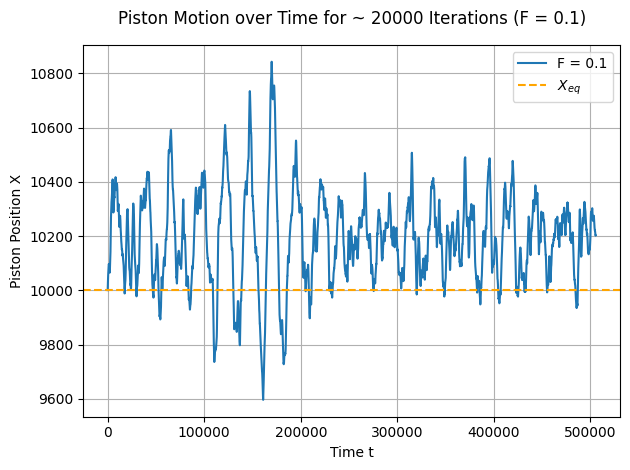

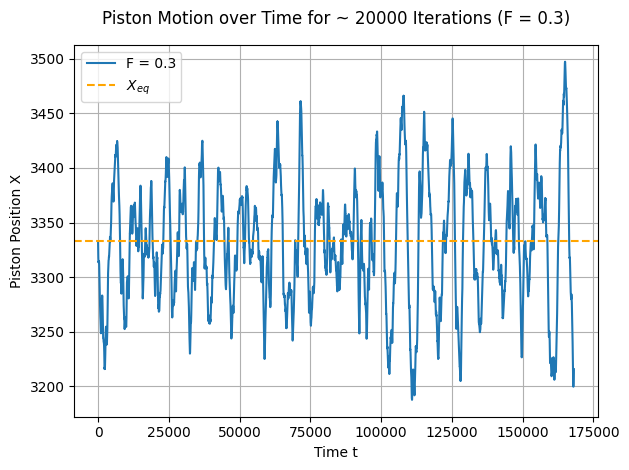

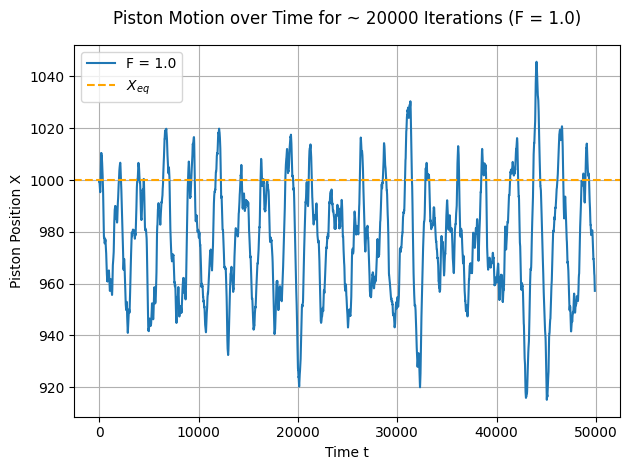

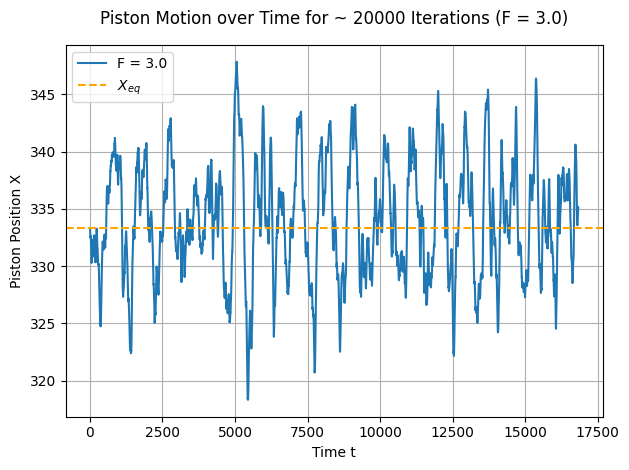

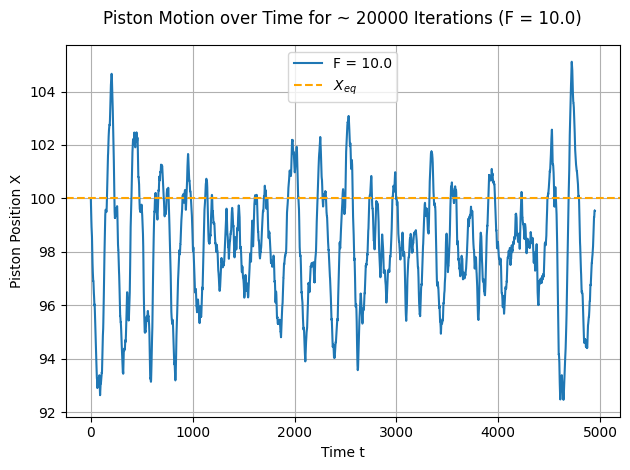

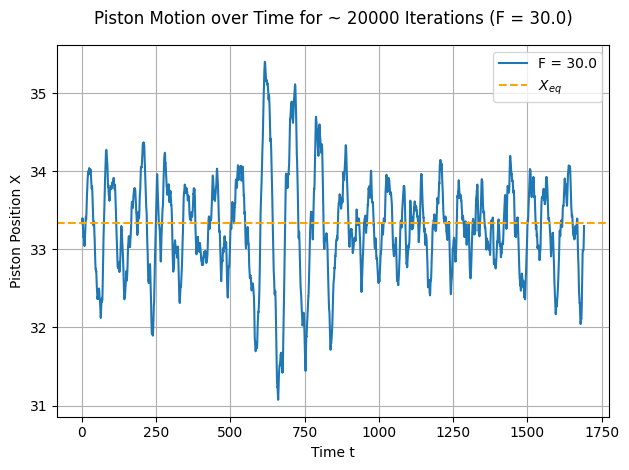

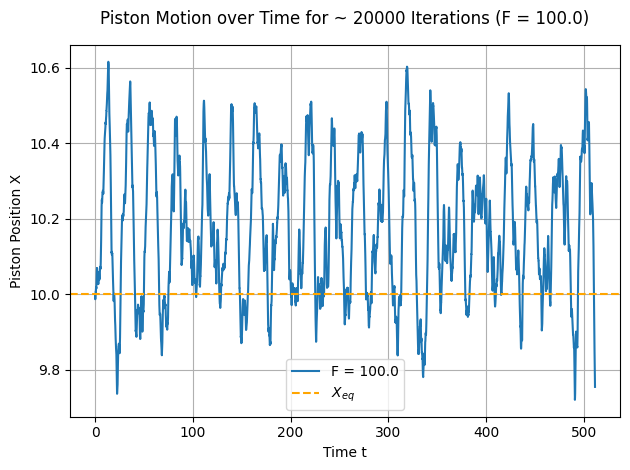

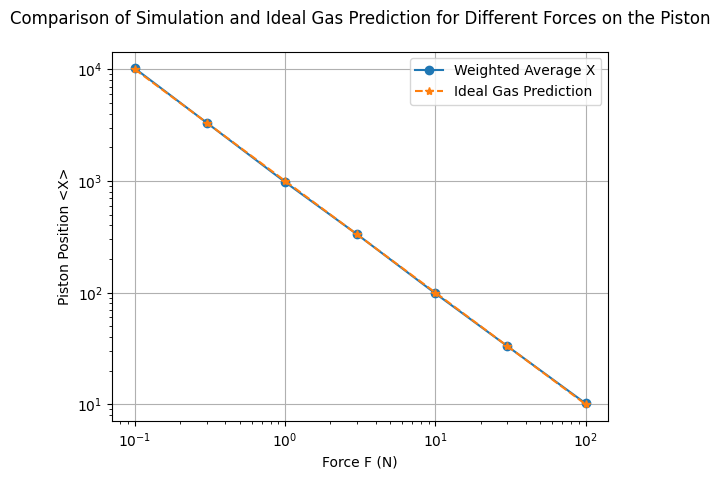

In [15]:
F_values = np.array([0.1, 0.3, 1, 3, 10, 30, 100])
#different forces acting on the piston

X_weight = np.empty_like(F_values, dtype=np.float64)
#holds weighted average piston positions
X_ideal = np.empty_like(F_values, dtype=np.float64)
#theroetical piston positions

for index, Force in enumerate(F_values):
    time_series, X_series, V_series, tau_series = simulation_2(N, T, kB, m, M, Force, int(n_iterations))

    final = slice(n_iterations // 2, n_iterations)
    #only takes second half of indices
    #discards initial transient behaviour to only look at steady state data

    X_avg = np.average(X_series[final], weights=tau_series[final])
    #calculating weighted average where weights are tau values for each iteration

    X_weight[index] = X_avg
    X_ideal[index] = (N * kB * T) / Force

    #plot individual forces
    plt.figure()
    plt.plot(time_series, X_series, label=f"F = {Force:.1f}")
    plt.axhline(y=X_ideal[index], color="orange", linestyle="--", label="$X_{eq}$")
    plt.xlabel("Time t")
    plt.ylabel("Piston Position X")
    plt.title(f"Piston Motion over Time for ~ {n_iterations} Iterations (F = {Force})", pad=15)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plt.figure()
plt.loglog(F_values, X_weight, 'o-', label="Weighted Average X")
plt.loglog(F_values, X_ideal, '*--', label="Ideal Gas Prediction")

plt.xlabel("Force F (N)")
plt.ylabel("Piston Position <X>")
plt.title("Comparison of Simulation and Ideal Gas Prediction for Different Forces on the Piston", pad=20)
plt.legend()
plt.grid(True)
plt.show()


# (c)

Show that an initial bi-polar distribution of the particles’ velocity tends towards the Maxwell distribution by storing all the velocities and plotting a sequence of histograms at a selection of time steps (minimum 7) as equilibrium is approached.
 - Change the initial particle velocities to be a random two-valued distribution.
 - Record at fine enough time intervals to really see the evolution from the bi-polar to Maxwell distribution.
 - Fit an appropriate theory curve (Gaussian?), report the mean and standard deviation of the fit.

*Comment on why the system thermalizes without interactions between the particles.*

In [16]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

def simulation_3(N, T, kB, m, M, F, n_iterations, steps, nbins):
    F_div_M = F / M
    X_eq = (N * kB * T) / F
    X = 2 * X_eq
    sigma_V = np.sqrt(kB * T / M)

    V = np.random.normal(0.0, sigma_V)

    positions = np.random.uniform(-X, X, int(N))
    v0 = np.sqrt(kB * T / m)
    velocities = np.where(np.random.rand(N) < 0.5, v0, -v0)
    #array of lenght N of randomly generated either v0 or -v0 values

    particles = np.empty((N, 2))
    particles[:, 0] = positions
    particles[:, 1] = velocities

    bins = np.linspace(-5 * v0, 5 * v0, nbins + 1)
    bin_centres = 0.5 * (bins[:-1] + bins[1:])
    #bins vary from -5 times to +5 times the initial particle velocity

    t = 0.0

    times = []
    hist_data = []

    for step in range(n_iterations):
        tau_min, index = next_collision(particles, X, V, F_div_M)
        particles, X, V = updating_xv(particles, X, V, F_div_M, tau_min, index, m, M)
        t += tau_min

        if step in steps:
            hist_counts, bin_edges = np.histogram(particles[:, 1], bins, density=True)
            times.append(t)
            hist_data.append(hist_counts)

    return np.array(hist_data), np.array(times), bin_centres


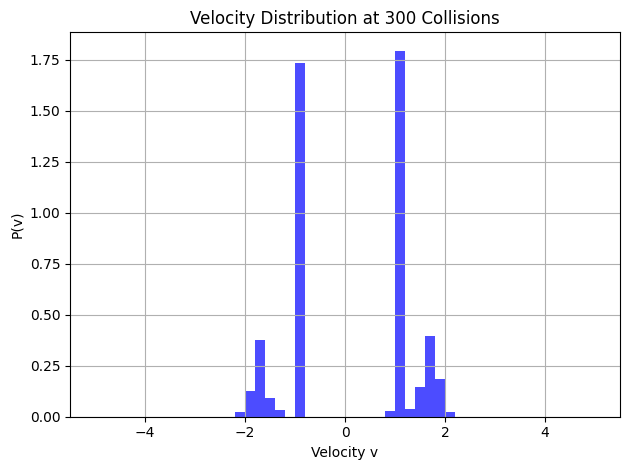

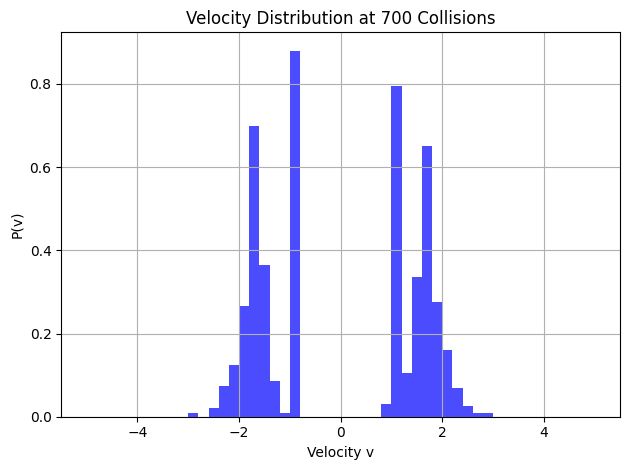

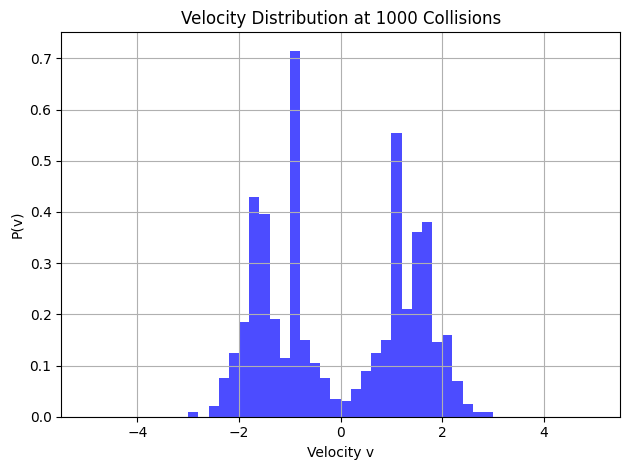

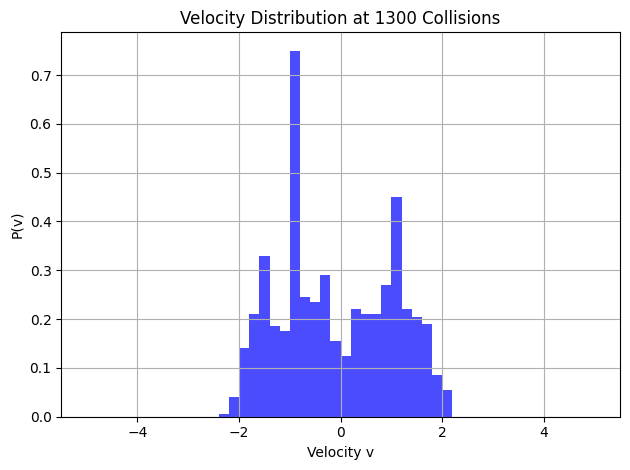

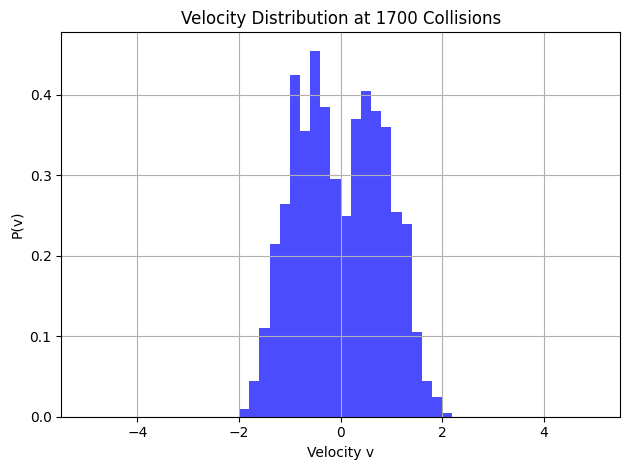

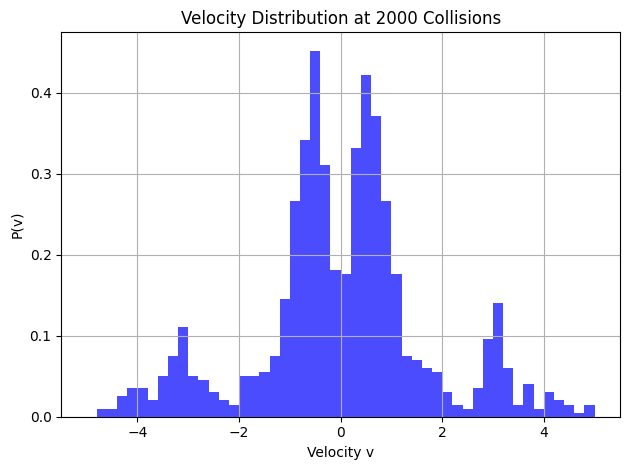

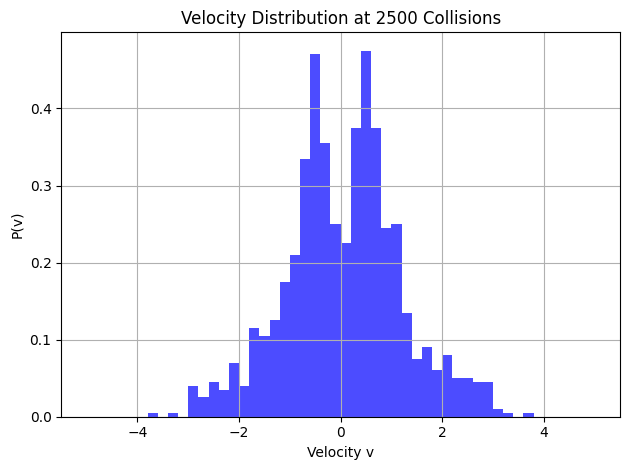

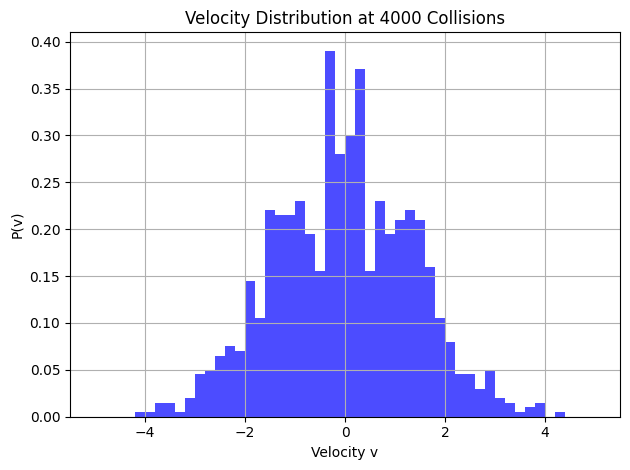

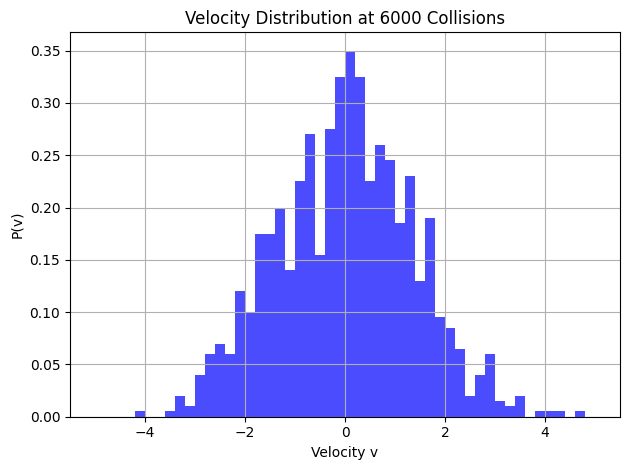

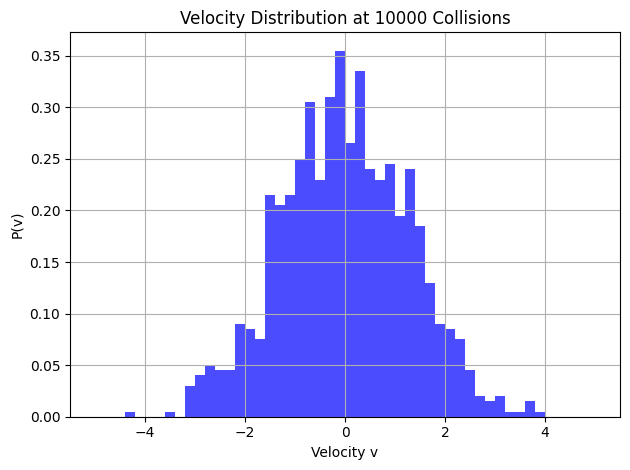

In [17]:
collision_numbers = [300,700,1000,1300,1700,2000,2500,4000,6000,10000]

hist_data, times, velocities = simulation_3(N, T, kB, m, M, F, int(n_iterations), collision_numbers, nbins=50)

for i, collision in enumerate(collision_numbers):
    plt.figure()
    bin_width = velocities[1] - velocities[0]
    plt.bar(velocities, hist_data[i], width=bin_width, color="blue", alpha=0.7, align="center")

    plt.xlabel("Velocity v")
    plt.ylabel("P(v)")
    plt.title(f"Velocity Distribution at {collision} Collisions")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


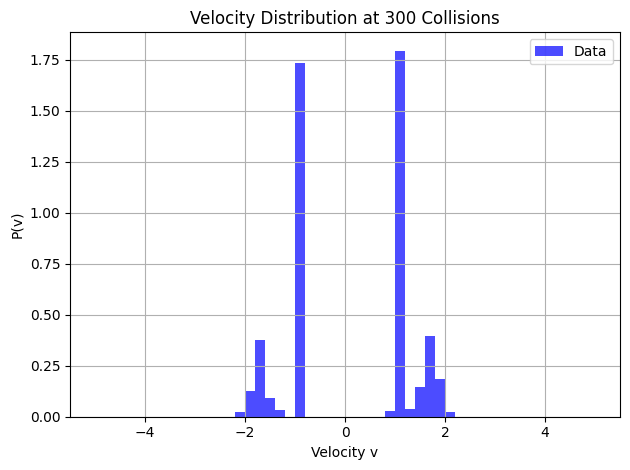

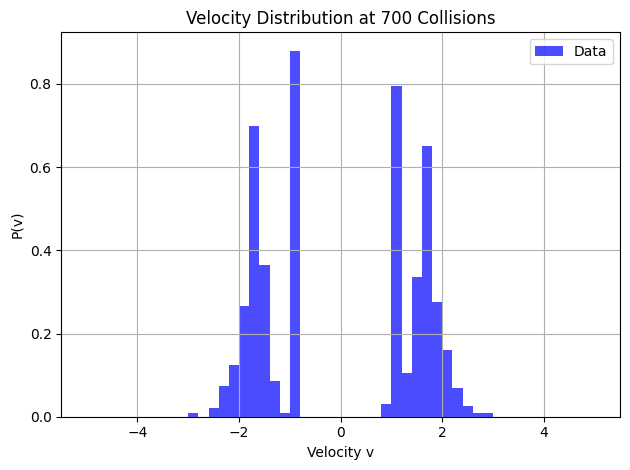

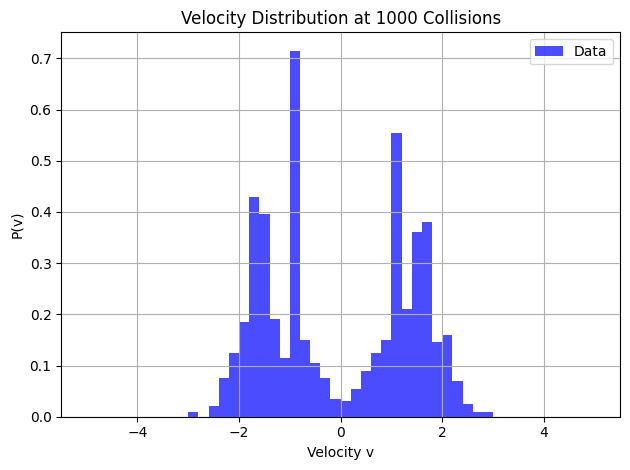

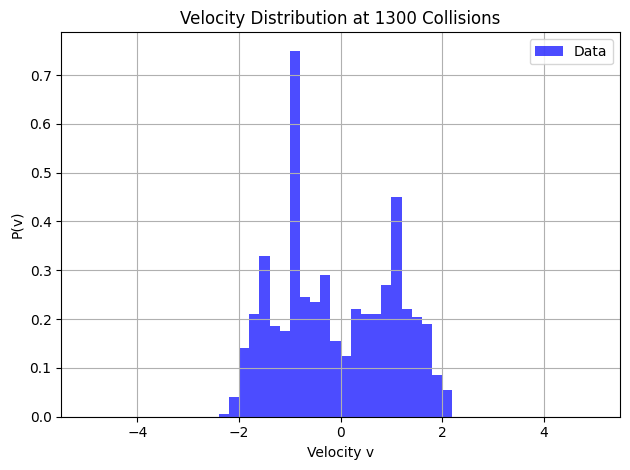

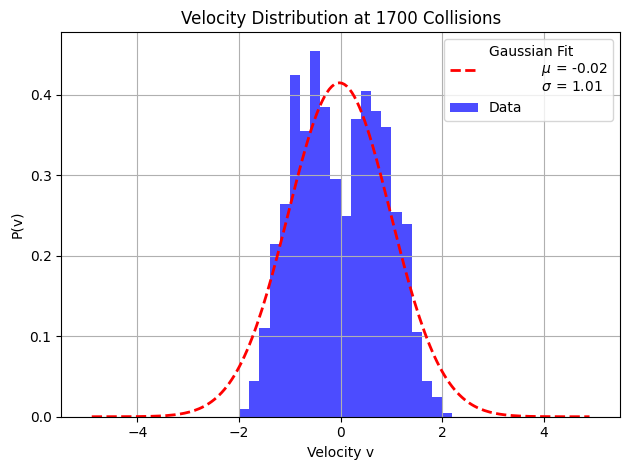

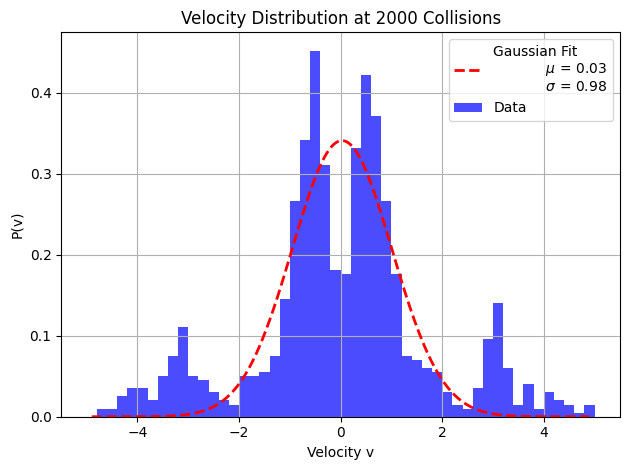

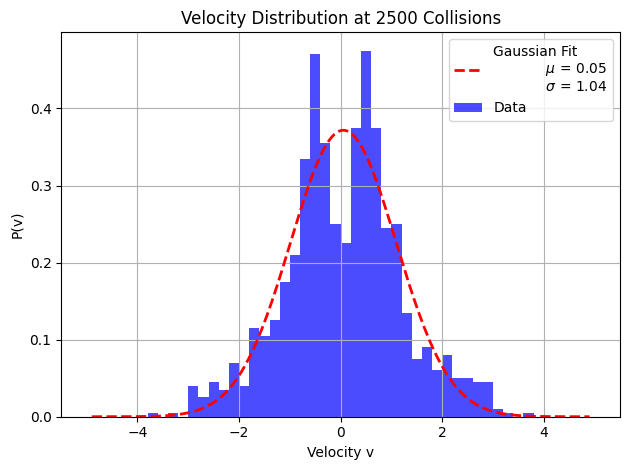

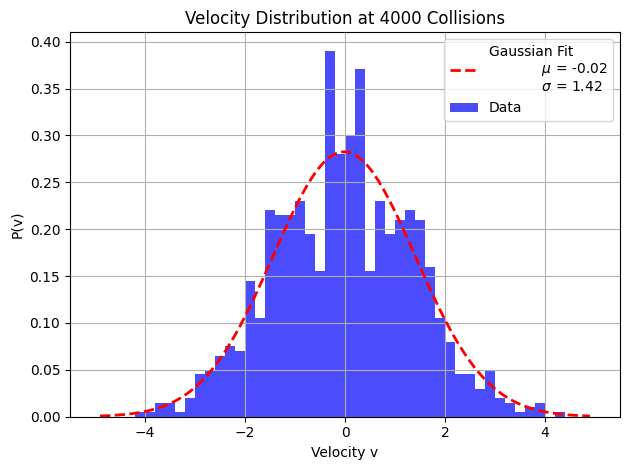

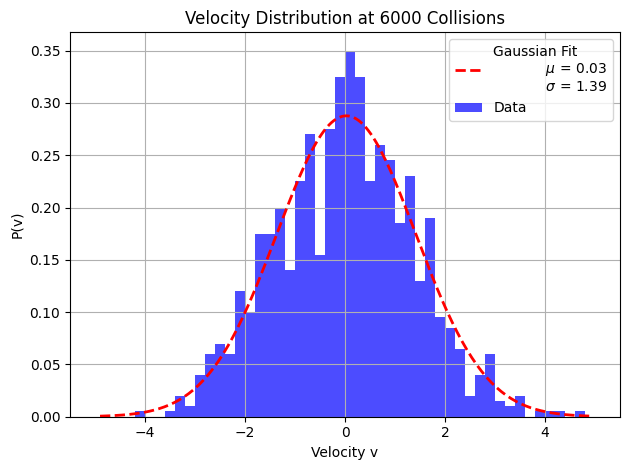

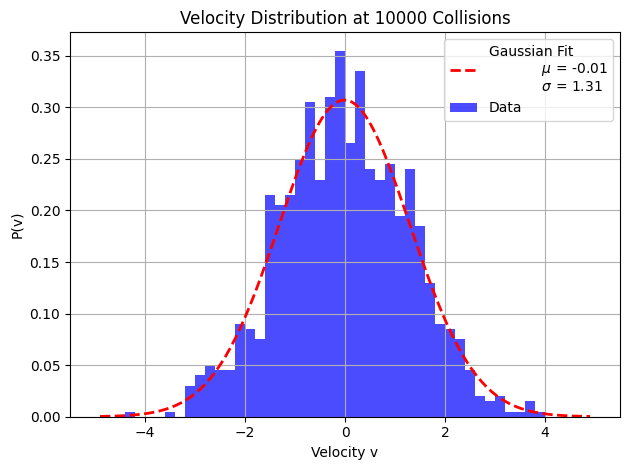

In [18]:
for i, collision in enumerate(collision_numbers):
    plt.figure()
    bin_width = velocities[1] - velocities[0]
    plt.bar(velocities, hist_data[i], width=bin_width, color='blue', alpha=0.7, align='center', label="Data",
            zorder=1)

    if collision > 1500:
        p0 = [np.max(hist_data[i]), 0, 1]
        try:
            popt, pcov = curve_fit(gaussian, velocities, hist_data[i], p0=p0)
            x_fit = np.linspace(velocities[0], velocities[-1], 200)
            y_fit = gaussian(x_fit, *popt)
            #popt parameters are A, mu, sigma

            label_text = fr"""Gaussian Fit
            $\mu$ = {popt[1]:.2f}
            $\sigma$ = {popt[2]:.2f}"""
            plt.plot(x_fit, y_fit, 'r--', lw=2, label=label_text, zorder=2)

        except RuntimeError:
            plt.text(0.5, 0.5, "Fit failed", transform=plt.gca().transAxes, ha='center')

    plt.xlabel("Velocity v")
    plt.ylabel("P(v)")
    plt.title(f"Velocity Distribution at {collision} Collisions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

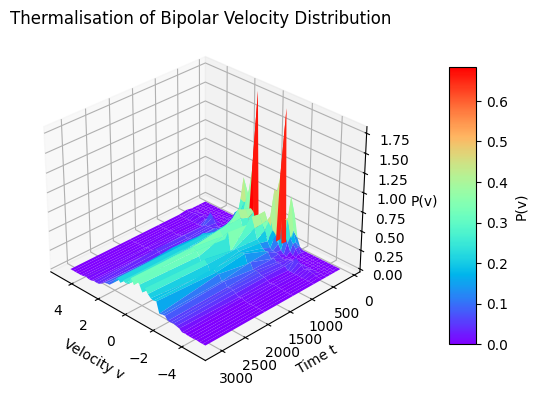

In [19]:
T_grid, V_grid = np.meshgrid(times, velocities, indexing="ij")
#ij uses matrix indexing

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(V_grid, T_grid, hist_data, cmap="rainbow")

ax.set_xlabel("Velocity v")
ax.set_ylabel("Time t")
ax.set_zlabel("P(v)")
ax.set_title("Thermalisation of Bipolar Velocity Distribution")

fig.colorbar(surf, ax=ax, shrink=0.75, aspect=10, label="P(v)", pad=0.15)
ax.view_init(elev=30, azim=135)
plt.show()


# (d)

## (i)

Check that the enthalpy **H** of this constant force system is conserved at all times as
the system approaches equilibrium by plotting *H vs t*, where the enthalpy is given by the answer to part (b):

$H_{1D}$ = $\frac{1}{2}\left(m\sum^N_{i=1}v_i^2+MV^2\right)+FX$

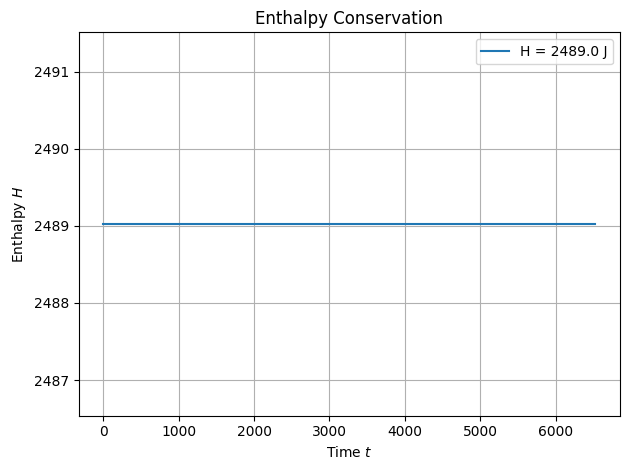

In [20]:
snapshot_steps = 20
#ie number of recorded data points

n_iterations = 20 * N
n_snapshots = n_iterations // snapshot_steps

enthalpy_series = np.empty(n_snapshots)
snapshot_times = np.empty(n_snapshots)

snap_index = 0
t = 0.0

for iteration in range(n_iterations):
    tau_min, index = next_collision(particles, X, V, F_div_M)
    particles, X, V = updating_xv(particles, X, V, F_div_M, tau_min, index, m, M)
    t += tau_min

    if iteration % snapshot_steps == 0:
        kinetic_gas = 0.5 * m * np.sum(particles[:, 1]**2)
        kinetic_piston = 0.5 * M * V**2
        total_energy = kinetic_gas + kinetic_piston

        enthalpy_series[snap_index] = total_energy + F * X
        snapshot_times[snap_index] = t
        snap_index += 1

plt.figure()
plt.plot(snapshot_times, enthalpy_series, label=f"H = {enthalpy_series[0]:.1f} J")
plt.ylim(min(enthalpy_series) * 0.999, max(enthalpy_series) * 1.001)
plt.xlabel("Time $t$")
plt.ylabel("Enthalpy $H$")
plt.title("Enthalpy Conservation")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#print(enthalpy_series)

## (ii)

Redo parts 3(a), (b), and (c) using SI units.

*Comment on what the physical size of system must be for the non-interacting gas molecule interpretation to be true at standard temperature and pressure.*

Force = 1.0544093808202028e-14 N, X0 = 0.0019641076205041286


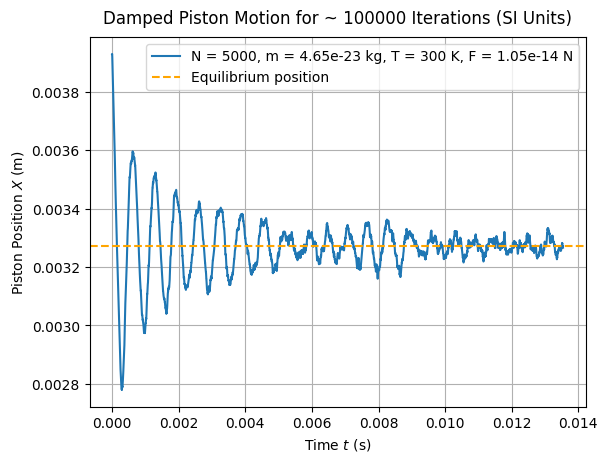

In [21]:
# part a

amu_to_grams = 1.66e-24

N = 5000
T = 300
kB = sc.k
m = 2 * 14.0067 * amu_to_grams #N2 gas molecule
M = 100 * m
n_iterations = 20 * N

#F chosen s.th. equ piston position X_eq = N * kB * T / F
#comes out in a small range  (~nm scale)
#also related to the mean free path of molecule - needs to rarely interact

"""X_eq = 20e-9
#set to be within range of atom diameter

F = (N * kB * T) / X_eq
"""

#new attempt

P = 101325 #Pa
N2_diameter = 3.64e-10
N2_area = np.pi * (N2_diameter / 2)**2

F = P * N2_area
X_eq = (N * kB * T) / F

X0 = X_eq
print(f"Force = {F} N, X0 = {X0}")

time_series, X_series, V_series, tau_series = simulation(N, T, kB, m, M, F, int(n_iterations))

plt.figure()
plt.plot(time_series, X_series, label=f"N = {N}, m = {m:.2e} kg, T = {T} K, F = {F:.2e} N")
plt.axhline(y=np.mean(X_series), color="orange", linestyle="--", label="Equilibrium position")

plt.xlabel("Time $t$ (s)")
plt.ylabel("Piston Position $X$ (m)")
plt.title(f"Damped Piston Motion for ~ {n_iterations} Iterations (SI Units)", pad=10)
plt.legend()
plt.grid()
plt.show()

1.0544093808202028e-14


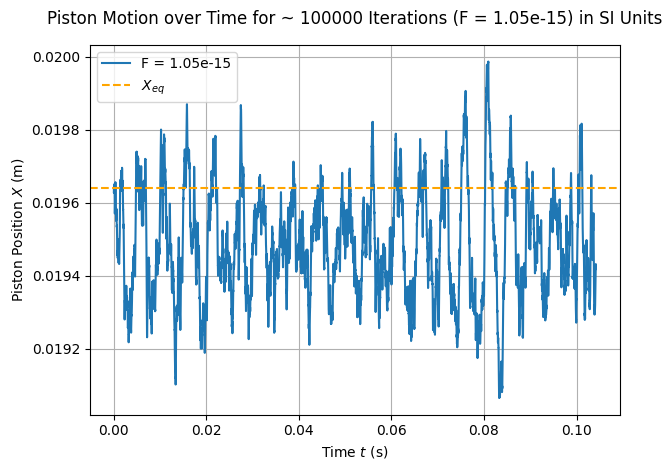

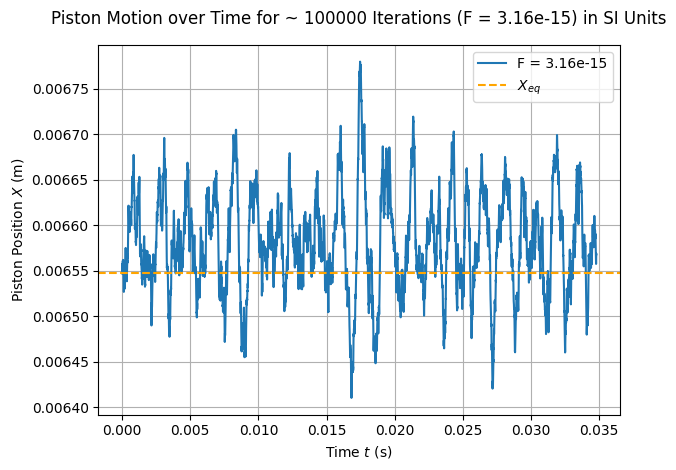

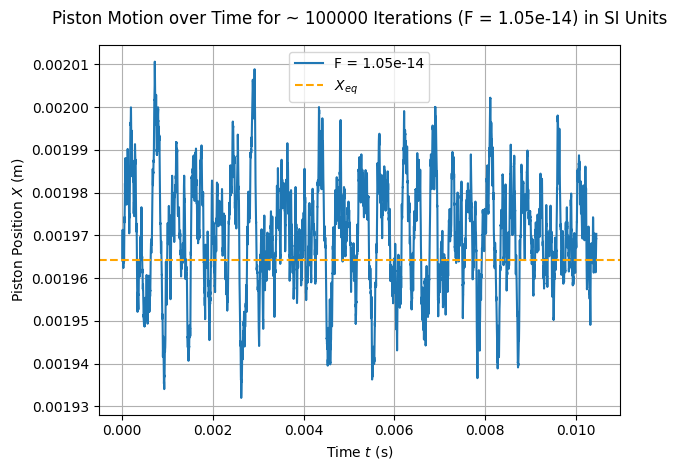

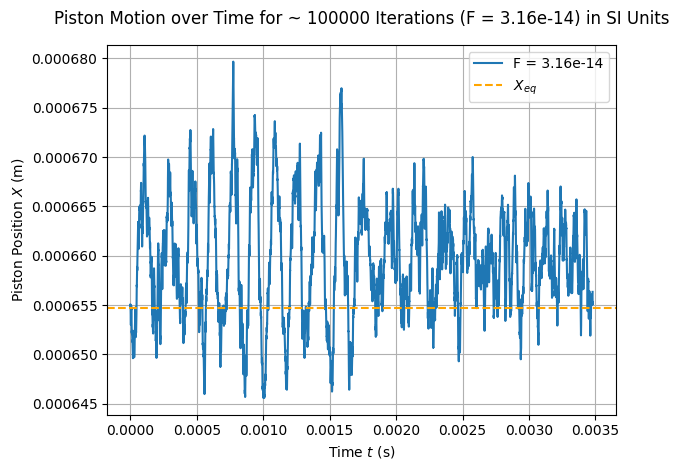

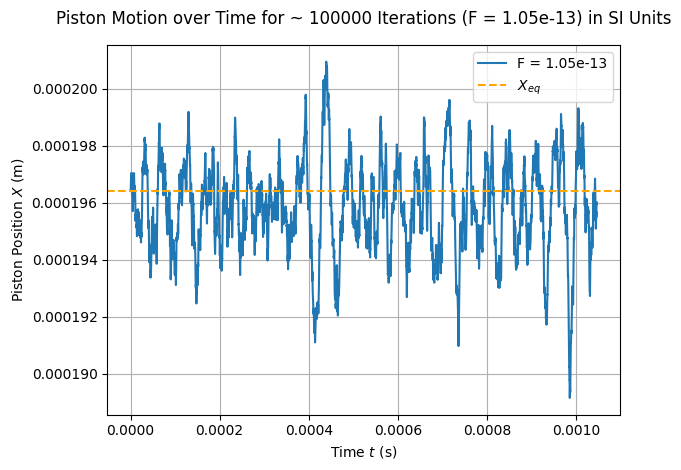

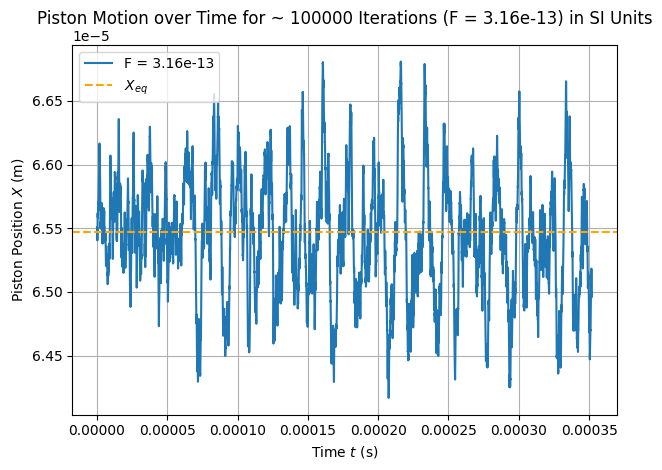

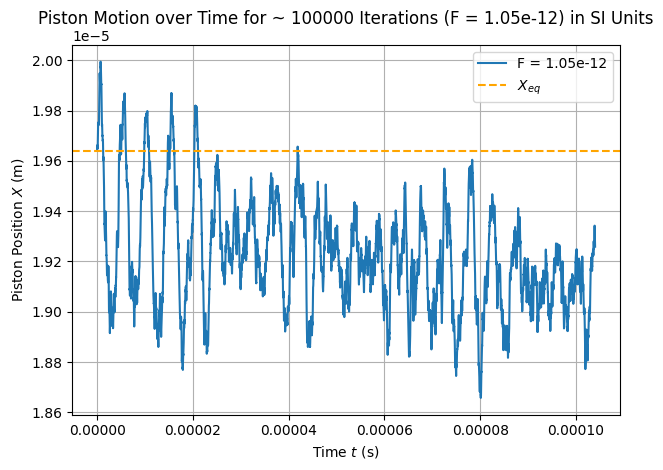

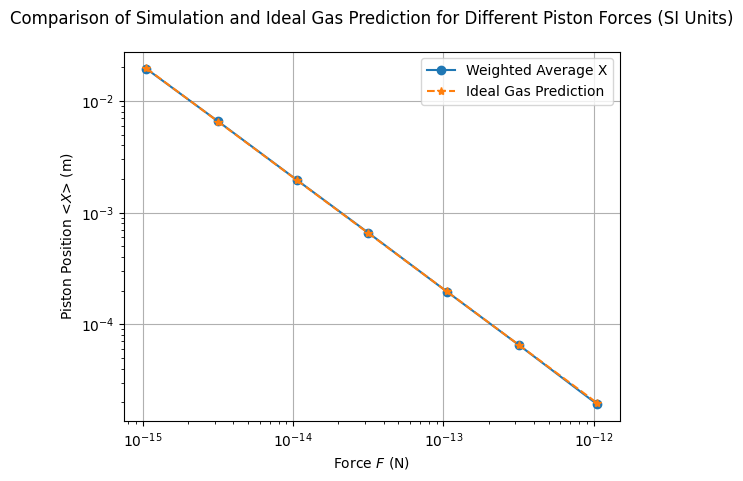

In [22]:
# part b

N = 5000
T = 300
kB = sc.k
m = 2 * 14.0067 * amu_to_grams #N2 gas molecule
M = 100 * m
P = 101325 #Pa
N2_diameter = 3.64e-10
N2_area = np.pi * (N2_diameter / 2)**2

F = P * N2_area
X_eq = (N * kB * T) / F
X0 = X_eq
#HAD TO REPASTE ^^ BECAUSE CODE KEPT USING PREVIOUS VALUES?

F_values = np.array([0.1, 0.3, 1, 3, 10, 30, 100]) * F
#different forces acting on the piston
print(F)
X_weight = np.empty_like(F_values, dtype=np.float64)
#holds weighted average piston positions
X_ideal = np.empty_like(F_values, dtype=np.float64)
#theroetical piston positions

for index, Force in enumerate(F_values):
    n_iterations = int(n_iterations)
    time_series, X_series, V_series, tau_series = simulation_2(N, T, kB, m, M, Force, int(n_iterations))

    final = slice(n_iterations // 2, n_iterations)
    #only takes second half of indices
    #discards initial transient behaviour to only look at steady state data

    X_avg = np.average(X_series[final], weights=tau_series[final])
    #calculating weighted average where weights are tau values for each iteration

    X_weight[index] = X_avg
    X_ideal[index] = (N * kB * T) / Force

    #plot individual forces
    plt.figure()
    plt.plot(time_series, X_series, label=f"F = {Force:.2e}")
    plt.axhline(y=X_ideal[index], color="orange", linestyle="--", label="$X_{eq}$")
    plt.xlabel("Time $t$ (s)")
    plt.ylabel("Piston Position $X$ (m)")
    plt.title(f"Piston Motion over Time for ~ {n_iterations} Iterations (F = {Force:.2e}) in SI Units", pad=15)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plt.figure()
plt.loglog(F_values, X_weight, 'o-', label="Weighted Average X")
plt.loglog(F_values, X_ideal, '*--', label="Ideal Gas Prediction")

plt.xlabel("Force $F$ (N)")
plt.ylabel("Piston Position <$X$> (m)")
plt.title("Comparison of Simulation and Ideal Gas Prediction for Different Piston Forces (SI Units)", pad=20)
plt.legend()
plt.grid(True)
plt.show()

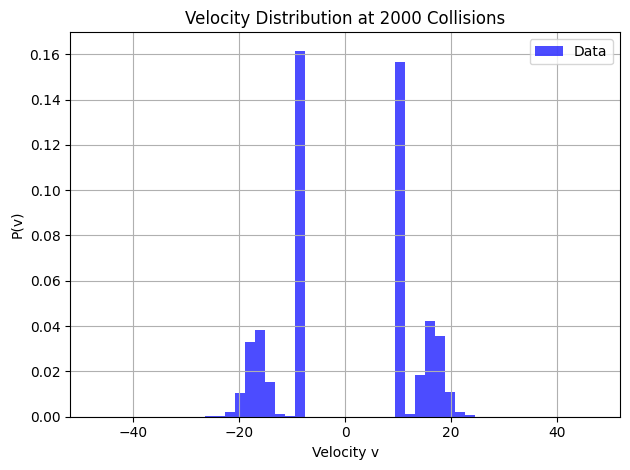

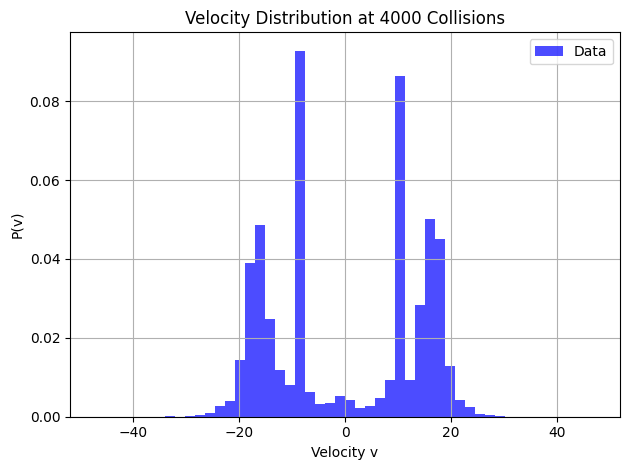

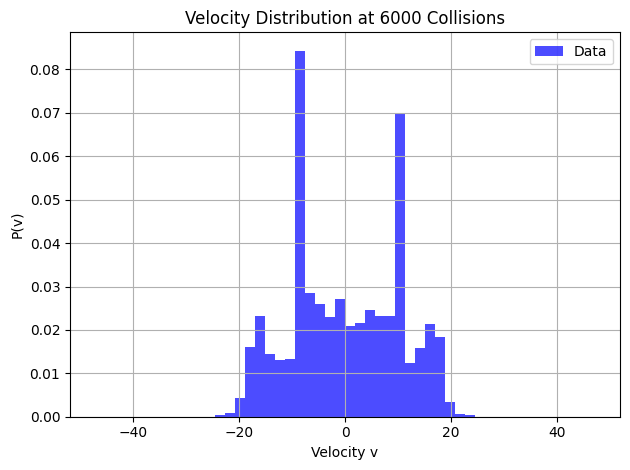

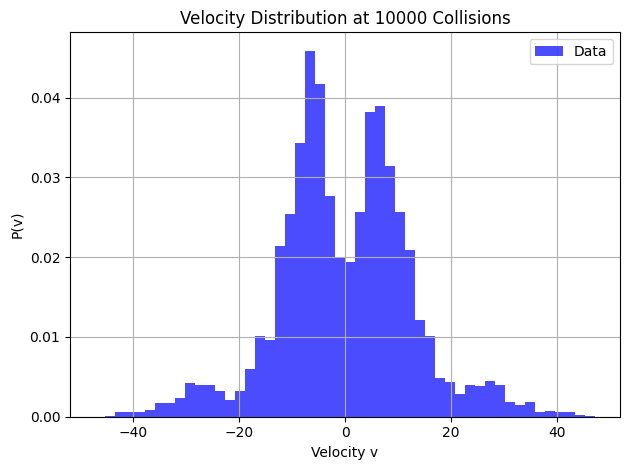

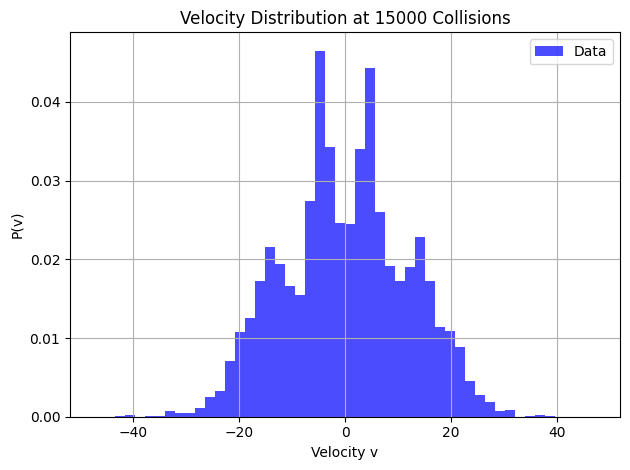

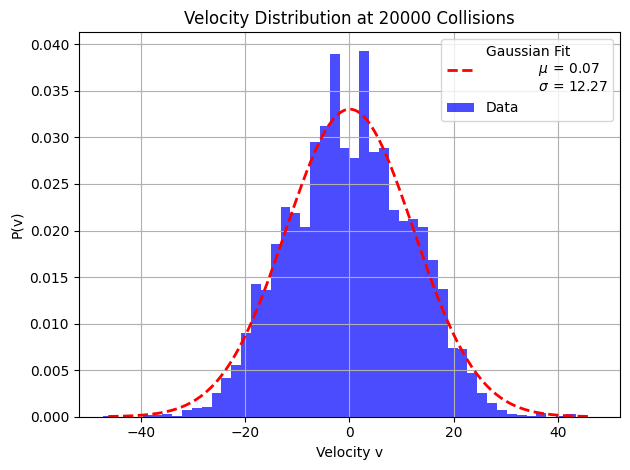

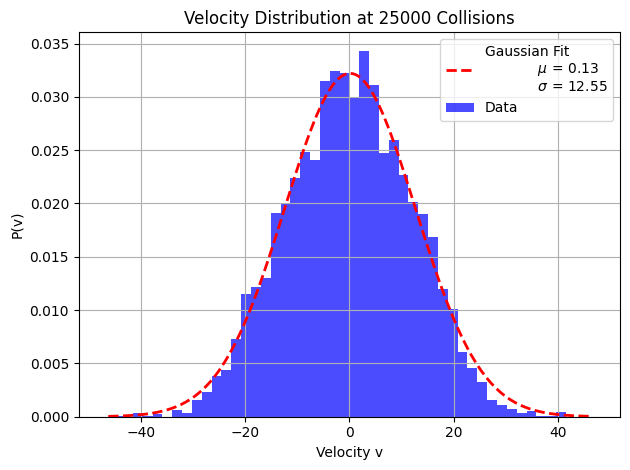

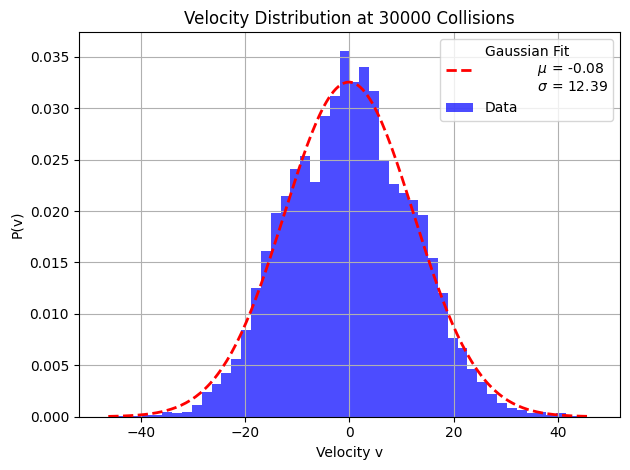

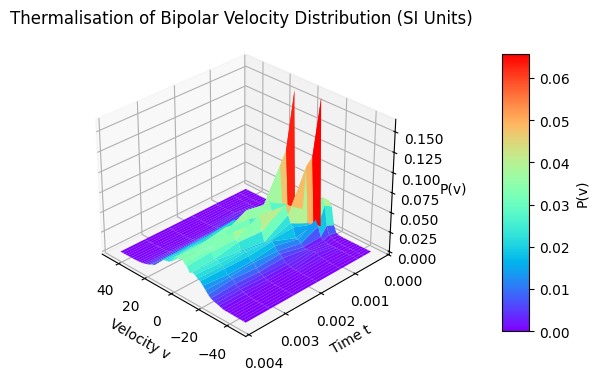

In [23]:
# part (c)

N = 5000
T = 300
kB = sc.k
m = 2 * 14.0067 * amu_to_grams #N2 gas molecule
M = 100 * m
P = 101325 #Pa
N2_diameter = 3.64e-10
N2_area = np.pi * (N2_diameter / 2)**2

F = P * N2_area
X_eq = (N * kB * T) / F
X0 = X_eq
#repaste again to ensure code uses the correct values

collision_numbers = [2000,4000,6000,10000,15000,20000,25000,30000]

hist_data, times, velocities = simulation_3(N, T, kB, m, M, F, int(n_iterations), collision_numbers, nbins=50)

for i, collision in enumerate(collision_numbers):
    plt.figure()
    bin_width = velocities[1] - velocities[0]
    plt.bar(velocities, hist_data[i], width=bin_width, color='blue', alpha=0.7, align='center', label="Data",
            zorder=1)

    if collision > 15000:
        p0 = [np.max(hist_data[i]), 0, 1]
        try:
            popt, pcov = curve_fit(gaussian, velocities, hist_data[i], p0=p0)
            x_fit = np.linspace(velocities[0], velocities[-1], 200)
            y_fit = gaussian(x_fit, *popt)
            #popt parameters are A, mu, sigma

            label_text = fr"""Gaussian Fit
            $\mu$ = {popt[1]:.2f}
            $\sigma$ = {popt[2]:.2f}"""
            plt.plot(x_fit, y_fit, 'r--', lw=2, label=label_text, zorder=2)

        except RuntimeError:
            plt.text(0.5, 0.5, "Fit failed", transform=plt.gca().transAxes, ha='center')

    plt.xlabel("Velocity v")
    plt.ylabel("P(v)")
    plt.title(f"Velocity Distribution at {collision} Collisions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

T_grid, V_grid = np.meshgrid(times, velocities, indexing="ij")
#ij uses matrix indexing

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(V_grid, T_grid, hist_data, cmap="rainbow")

ax.set_xlabel("Velocity v")
ax.set_ylabel("Time t")
ax.set_zlabel("P(v)")
ax.set_title("Thermalisation of Bipolar Velocity Distribution (SI Units)")

fig.colorbar(surf, ax=ax, shrink=0.75, aspect=10, label="P(v)", pad=0.2)
ax.view_init(elev=30, azim=135)
plt.show()

## (iii)

*Does the system settle down asymptotically to the ideal gas expected value, or does it keep fluctuating if the system is run much longer?*

*What happens if you increase and
decrease the value of N by a factor of 10*?

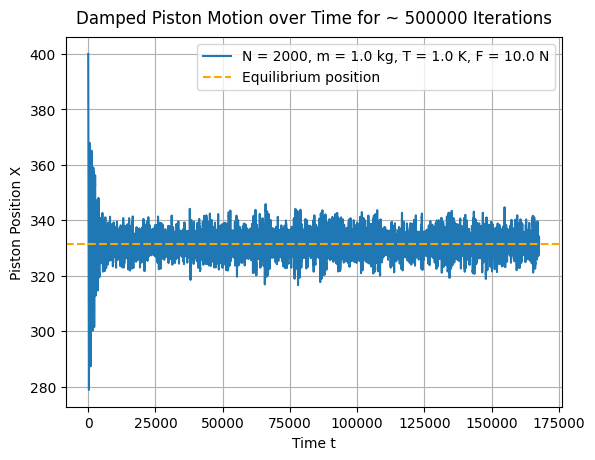

In [24]:
N = 2000
T = 1.0
kB = 1.0
m = 1.0
M = 100.0
F = 10.0

n_iterations = 250 * N

time_series, X_series, V_series, tau_series = simulation(N, T, kB, m, M, F, int(n_iterations))

plt.figure()
plt.plot(time_series, X_series, label=f"N = {N}, m = {m} kg, T = {T} K, F = {F} N")
plt.axhline(y=np.mean(X_series), color="orange", linestyle="--", label="Equilibrium position")

plt.xlabel("Time t")
plt.ylabel("Piston Position X")
plt.title(f"Damped Piston Motion over Time for ~ {n_iterations} Iterations", pad=10)
plt.legend()
plt.grid()
plt.show()

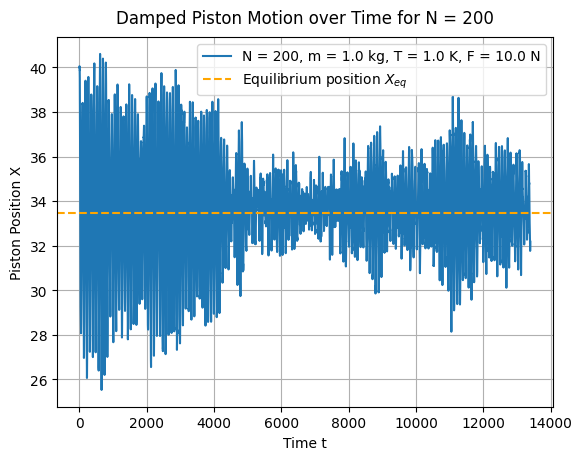

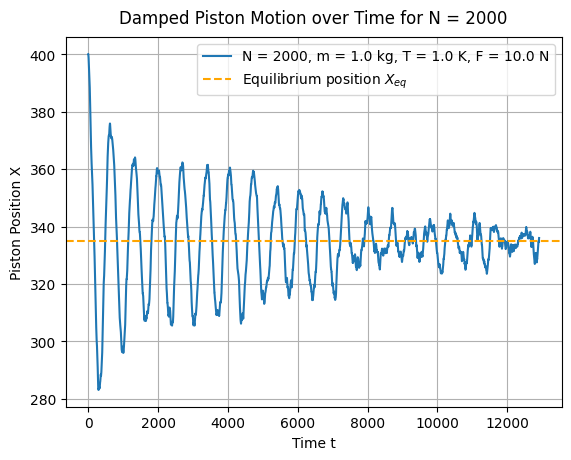

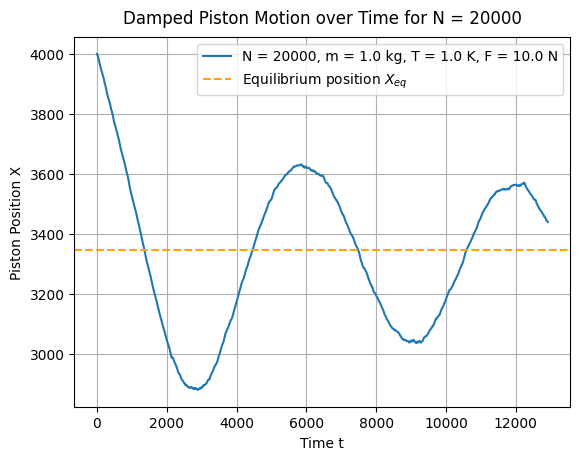

In [25]:
N = 2000
T = 1.0
kB = 1.0
m = 1.0
M = 100.0
F = 10.0

n_iterations = 20 * N

N_values = np.array([1e-1, 1, 1e1]) * N
N_values = N_values.astype(int)

for N_varied in N_values:
    N_varied = int(N_varied)

    time_series, X_series, V_series, tau_series = simulation(N_varied, T, kB, m, M, F, int(n_iterations))

    plt.figure()
    plt.plot(time_series, X_series, label=f"N = {N_varied}, m = {m} kg, T = {T} K, F = {F} N")
    plt.axhline(y=np.mean(X_series), color="orange", linestyle="--", label=r"Equilibrium position $X_{eq}$")

    plt.xlabel("Time t")
    plt.ylabel("Piston Position X")
    plt.title(f"Damped Piston Motion over Time for N = {N_varied}", pad=10)
    plt.legend()
    plt.grid()
    plt.show()


## (iv) and (v)

How could some weak interaction between the particles be added? Try this with a
smaller number of particles to see how the system thermalizes, describing how you
add the interaction and show how much interaction you need to introduce to cause a
noticeable difference to zero interaction.

The algorithm is quite slow, because it requires evaluating $\tau$ for every particle to
update for just one collision. Devise and implement a way to reduce the number of
particles evaluated and run the model for much longer times, including the case with
interactions.